# Pre-Processing

This notebook contains the necessary pre-processing steps and modeling steps.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#import warnings
#warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 32)

In [2]:
#Loading data
bookings = pd.read_csv('post_eda_bookings.csv')
bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,0,0,0,A,C,0,No Deposit,-1.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
1,0,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,0,0,0,A,A,0,No Deposit,304.0,0,Transient,75.0,0,0,Check-Out,2015-07-02
2,0,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,0,0,0,A,A,0,No Deposit,240.0,0,Transient,98.0,0,1,Check-Out,2015-07-03
3,0,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,0,0,0,C,C,0,No Deposit,-1.0,0,Transient,107.0,0,0,Check-Out,2015-07-03
4,0,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,0,0,0,C,C,0,No Deposit,303.0,0,Transient,103.0,0,1,Check-Out,2015-07-03


## Feature Reduction

In [3]:
#Exploring columns
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86249 entries, 0 to 86248
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           86249 non-null  int64  
 1   is_canceled                     86249 non-null  int64  
 2   lead_time                       86249 non-null  int64  
 3   arrival_date_year               86249 non-null  int64  
 4   arrival_date_month              86249 non-null  object 
 5   arrival_date_week_number        86249 non-null  int64  
 6   arrival_date_day_of_month       86249 non-null  int64  
 7   stays_in_weekend_nights         86249 non-null  int64  
 8   stays_in_week_nights            86249 non-null  int64  
 9   adults                          86249 non-null  int64  
 10  children                        86249 non-null  float64
 11  babies                          86249 non-null  int64  
 12  meal                            

In [4]:
#Looking at the number of unique values for categorical features. Including agent id column
cat = list(bookings.select_dtypes(include=['object']).columns)
cat.append('agent')
bookings[cat].nunique()

arrival_date_month          12
meal                         4
country                    178
market_segment               8
reserved_room_type          10
assigned_room_type          12
deposit_type                 3
customer_type                4
reservation_status           3
reservation_status_date    924
agent                      334
dtype: int64

I'll take a look at the country column and try to reduce the number of unique values. I'm also taking a look at the agent column. The agent column is a numeric id for the travel agency that booked the reservation. I want to see if there's a particular agency that's used more frequently than others. I'm getting rid of reservation_statatus_date and the reservation_status columns. The relevant information for what happened with a reservation is already stored in the is_canceled column. 

In [5]:
#Dropping unnecessary columns
df= bookings.drop(['reservation_status', 'reservation_status_date'], axis=1)

### agent column

In [6]:
#Looking at the count of the values
df['agent'].value_counts().head()

 9.0      28655
 240.0    12899
-1.0      11854
 14.0      3330
 7.0       3280
Name: agent, dtype: int64

In [7]:
#Looking at the percentages
(df['agent'].value_counts()/len(df)).head()

 9.0      0.332236
 240.0    0.149555
-1.0      0.137439
 14.0     0.038609
 7.0      0.038029
Name: agent, dtype: float64

In [8]:
df['market_segment'][df['agent']==9]

209         Direct
4993        Direct
11020    Corporate
11369    Corporate
11370    Corporate
           ...    
86238    Online TA
86239    Online TA
86245    Online TA
86246    Online TA
86248    Online TA
Name: market_segment, Length: 28655, dtype: object

It looks like the majority of the reservations were made through the agencies with id 9 and id 240. The -1 represent missing values. I'll simplify the column using 0, 1 and 2. 1 representing all the reservations made through agency 9, 2 for reservations made through agency 240 and 0 for the rest.

In [9]:
df['agent'] = df['agent'].apply(lambda x: 1 if x==9 else (2 if x==240 else 0))

### country column

In [10]:
#Exploring unique values of the country column
df['country'].value_counts().head(10)

PRT    26618
GBR    10378
FRA     8788
ESP     7192
DEU     5369
ITA     3049
IRL     3011
BEL     2074
BRA     1987
NLD     1907
Name: country, dtype: int64

In [11]:
#Looking at the percentages of the values
(df['country'].value_counts()/len(df)).head(10)

PRT    0.308618
GBR    0.120326
FRA    0.101891
ESP    0.083386
DEU    0.062250
ITA    0.035351
IRL    0.034911
BEL    0.024047
BRA    0.023038
NLD    0.022110
Name: country, dtype: float64

In [12]:
#Grouping the countries that account for less than 1% of the column into 'Other'
pct = (df['country'].value_counts()/len(df))
mask = df['country'].isin(pct[pct<0.01].index)
df['country'][mask] = 'Other'
df['country'].nunique()

C:\Users\saint\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


15

## Dummy encoding

In [13]:
#Defining X
X = df.drop('is_canceled', axis=1)

#Dummy encoding X
X = pd.get_dummies(X, drop_first=True)

In [14]:
#Looking at how many columns I'll be working with
X.shape

(86249, 79)

In [15]:
#Defining my response variable. Using ravel() to get a flattened array
y= df['is_canceled'].ravel()

## Splitting the data into training set and test set

In [16]:
#Leaving 25% of my data for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=12)

## Scaling the data

In [17]:
#Instantiating a scaler
sc = StandardScaler()

#Fitting the scaler to the training set and transforming it
X_train_scaled = sc.fit_transform(X_train)

#Scaling test set
X_test_scaled = sc.transform(X_test)

# Modeling

The steps below will invove modeling, model selection and model evaluation. I'll be using the following models:

* Logistic Regression
* Random Forest
* Adaptive Boosting
* Extreme Gradient Boosting

## Logisitc Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Only tuning C for my Logistic Regression model
params = {'C':[0.001,0.01,0.1,1,10,100,None]}
logreg = LogisticRegression(random_state=21)

logreg_cv = GridSearchCV(logreg, param_grid=params, scoring='accuracy', n_jobs=-1, cv=5)
logreg_cv.fit(X_train_scaled, y_train)

print(logreg_cv.best_params_)
print('Best accuracy using logistic regression: {}'.format(logreg_cv.best_score_))

{'C': 100}
Best accuracy using logistic regression: 0.7995547885824991


C:\Users\saint\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

#Parameters grid for random forest model
params_rf = {'n_estimators':[500], 'criterion':['gini', 'entropy'], 'max_depth' :[5, 10, 15, 25, 30, None],
            'min_samples_split':np.arange(2,11,2), 'min_samples_leaf':np.arange(1,11,1)}
rf = RandomForestClassifier(random_state=21)

randomized_rf = RandomizedSearchCV(rf, param_distributions=params_rf, n_iter=100, cv=4, scoring='accuracy', 
                                   n_jobs=-1, verbose=1)
randomized_rf.fit(X_train_scaled, y_train)
print(randomized_rf.best_params_)
print('Best accuracy using random forest: {}'.format(randomized_rf.best_score_))

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 51.9min finished


{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini'}
Best accuracy using random forest: 0.8488544732157262


In [20]:
randomized_rf

RandomizedSearchCV(cv=4, estimator=RandomForestClassifier(random_state=21),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 10, 15, 25, 30, None],
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([100, 200, 300, 400, 500])},
                   scoring='accuracy', verbose=1)

## Adaptive Boosting

In [21]:
from sklearn.ensemble import AdaBoostClassifier

#Parameters for the adaptive boosting model
params_ada = {'n_estimators':np.arange(100,600,100), 'learning_rate': np.arange(0.05,1.05,.05)}

ada = AdaBoostClassifier(random_state=21)

randomized_ada = RandomizedSearchCV(ada, param_distributions=params_ada, n_iter=15, cv=5, scoring='accuracy', 
                                    n_jobs=-1, verbose=1)
randomized_ada.fit(X_train_scaled, y_train)
print(randomized_ada.best_params_)
print('Best accuracy using adaptive boosting: {}'.format(randomized_ada.best_score_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 18.5min finished


{'n_estimators': 500, 'learning_rate': 0.6000000000000001}
Best accuracy using adaptive boosting: 0.8143338982033972


## Extreme Gradient Boosting

In [22]:
import xgboost as xgb

#Parameters for the xgboost model
params_xgb = {'learning_rate':np.arange(0.05,1.05,.05), 'max_depth' :[5, 10, 15, 25, 30], 
             'gamma':[0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
             'n_estimators':np.arange(100,1001,100), 'subsample':np.arange(0.2,1.1,0.1), 
              'colsample_bytree':np.arange(0.2,1.1,0.1), 'reg_alpha': np.arange(0,1.1, 0.25),
              'reg_lambda': np.arange(1,5.5,0.5), 'min_child_weight':np.arange(1,9,2)}

xgb = xgb.XGBClassifier(objective= 'binary:logistic', tree_method = "hist", predictor = "cpu_predictor",
                        random_state=21)

randomized_xgb = RandomizedSearchCV(xgb, param_distributions=params_xgb, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1,
                                   verbose=1)
randomized_xgb.fit(X_train_scaled, y_train)
print(randomized_xgb.best_params_)
print('Best accuracy using extreme gradient boosting: {}'.format(randomized_xgb.best_score_))

C:\Users\saint\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 60.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 67.3min finished


{'subsample': 0.8000000000000003, 'reg_lambda': 3.0, 'reg_alpha': 0.25, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8000000000000003}
Best accuracy using extreme gradient boosting: 0.8501531047167914


In [23]:
pd.DataFrame({'Models':['Linear Regression', 'Random Forest', 'Adaptive Boosting', 'Extreme Gradient Boosting'], 
              'Accuracy_Scores':[logreg_cv.best_score_, randomized_rf.best_score_, randomized_ada.best_score_, 
                                 randomized_xgb.best_score_]}).sort_values(by=['Accuracy_Scores'])

,Models,Accuracy_Scores
0,Linear Regression,0.799555
2,Adaptive Boosting,0.814334
1,Random Forest,0.848854
3,Extreme Gradient Boosting,0.850153


Since the accuracy scores of the Random Forest and the Extreme Gradient Boosting models are fairly close I'll look deeper in those. In the next steps I'll create a new models using the best parameters found through the random search cross validation and proceed to look into their:
* Classification Reports
* Confusion Matrices
* ROC AUC Curves
* Precision vs Recall Curves
* Feature Importance Plots

# Optimal Random Forest

In [36]:
#Tuned hyperparameters
estimators= randomized_rf.best_params_['n_estimators']
split = randomized_rf.best_params_['min_samples_split']
leaf = randomized_rf.best_params_['min_samples_leaf']
depth = randomized_rf.best_params_['max_depth']
crit= randomized_rf.best_params_['criterion']

#Optimal model
rfo = RandomForestClassifier(random_state=21, n_estimators= estimators, min_samples_split= split, min_samples_leaf= leaf, 
                             max_depth= depth, criterion= crit)
rfo.fit(X_train_scaled, y_train)
y_pred_rf = rfo.predict(X_test_scaled)

### Classification Report

In [37]:
from sklearn.metrics import classification_report, accuracy_score
print('Accuracy: {}'.format(round(accuracy_score(y_test, y_pred_rf),4)))
print(classification_report(y_test, y_pred_rf))

Accuracy: 0.854
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15683
           1       0.76      0.67      0.71      5880

    accuracy                           0.85     21563
   macro avg       0.82      0.80      0.81     21563
weighted avg       0.85      0.85      0.85     21563



### Confussion Matrix

Confusion matrix, without normalization
[[14468  1215]
 [ 1933  3947]]
Normalized confusion matrix
[[0.92 0.08]
 [0.33 0.67]]


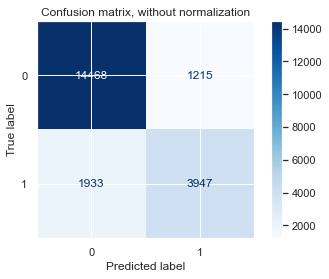

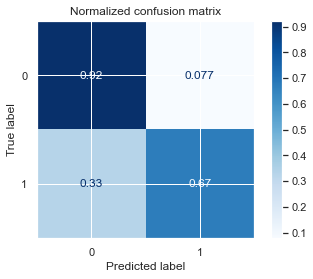

In [38]:
class_names=[0,1]
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf) #confusion matrix without normalization
cm_norm = cm / cm.astype(np.float).sum(axis=1, keepdims=True) #normalizing the matrix
np.set_printoptions(precision=2)

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

#Using plot_confusion_matrix for better visualization
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfo, X_test_scaled, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### ROC AUC Curve

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
print('Area under the ROC Curve for Random Forest model: {}'.format(roc_auc_score(y_test, y_pred_rf)))

Area under the ROC Curve for Random Forest model: 0.7968930405165956


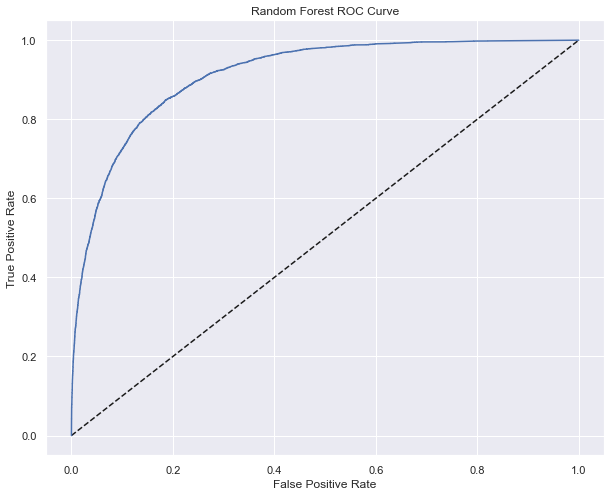

In [40]:
#Plotting the ROC Curve of the Random Forest model
y_pred_prob_rf = rfo.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
sns.set()
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

### Precision/Recall Curve

In [41]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test,y_pred_prob_rf)
print('Area under the Precision/Recall Curve for the Random Forest model: {}'.format(auc(recall, precision)))

Area under the Precision/Recall Curve for the Random Forest model: 0.8062392627444852


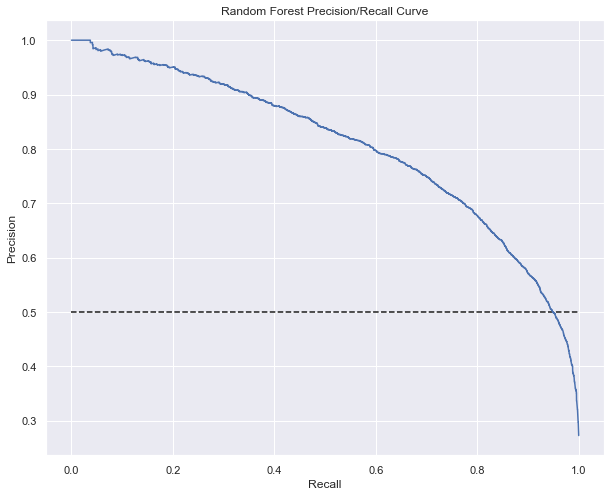

In [42]:
#Plotting the Precision/Recall Curve of the Random Forest model
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0.5,0.5], 'k--')
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision/Recall Curve')
plt.show()

### Feature Importance Plot

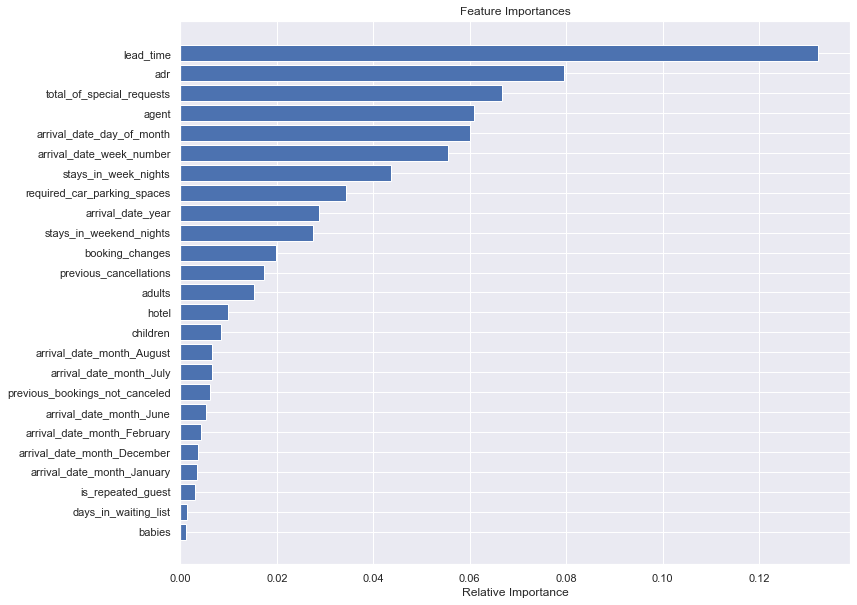

In [43]:
#Getting the name of my features
features = X.columns
#Getting the importance of the top 25 features
feature_importance = rfo.feature_importances_[:25]
indices = np.argsort(feature_importance)[:25]

plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Optimal Extreme Gradient Boosting

In [44]:
randomized_xgb.best_params_

{'subsample': 0.8000000000000003,
 'reg_lambda': 3.0,
 'reg_alpha': 0.25,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.5,
 'colsample_bytree': 0.8000000000000003}

#Tuned hyperparameters
sub = randomized_xgb.best_params_['subsample']
lamb = randomized_xgb.best_params_['reg_lambda']
alpha = randomized_xgb.best_params_['reg_alpha']
estimatorx = randomized_xgb.best_params_['n_estimators']
weight = randomized_xgb.best_params_['min_child_weight']
mx_depth = randomized_xgb.best_params_['max_depth']
lrn_rate = randomized_xgb.best_params_['learning_rate']
gamma = randomized_xgb.best_params_['gamma']
colsamp = randomized_xgb.best_params_['colsample_bytree']

#Optimal model
xbgo = xgb.XGBClassifier(random_state=21)